In [1]:
#!pip install segmentation-models-pytorch
#!pip install torchmetrics
#!pip install torch_snippets==0.538.1
#!pip install pytorch_model_summary
!pip install lunar_image_processor/
!pip install torchsummary
!pip install opencv-python

from IPython.display import clear_output
clear_output()

In [37]:

import numpy as np
import math
from PIL import Image
import shutil
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
import random
import copy


import torch
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn

cudnn.benchmark = True
import torch.nn as nn

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
import torchmetrics

from torchsummary import summary
from torch_snippets import *
from torch_snippets import Report

from tqdm import tqdm


from lunar_image_processor.lunar_utils import create_patches, create_split_folders, split_train_test_val_folders, preprocess_data, delete_split_folders
#%% Constants
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"

In [38]:
data_dir = Path('drive/MyDrive/MoonImages/')
working_dir = working_dir = Path('.') #Path('drive/MyDrive/MoonWorking/')
render_dir = data_dir/"render/"


delete_split_folders(working_dir)
create_split_folders(working_dir)
train_list, val_list, test_list = split_train_test_val_folders(render_dir, train_ratio=0.7, val_ratio=0.15)
preprocess_data(data_dir, working_dir, train_list, val_list, test_list)

In [39]:
def get_images_and_masks(path_name):
    image_names = os.listdir(f"{path_name}/images")
    masks_names = os.listdir(f"{path_name}/masks")

    # filter all images that do not exist in both folders
    img_stem = [i.replace('render', '')for i in image_names]
    msk_stem = [i.replace('clean', '')  for i in masks_names]

    #ensure that images and masks correspond to each other
    img_msk_stem = set(img_stem) & set(msk_stem)

    image_paths = [f"{path_name}/images/render{i}" for i in img_msk_stem]
    mask_paths = [f"{path_name}/masks/clean{i}" for i in img_msk_stem]

    # return images and masks
    return image_paths, mask_paths

In [40]:
def get_original_height_width(path_name):
    image_names = os.listdir(f"{path_name}/images")

    #val_path_name = os.path.join(working_dir, 'val')

    image_path = f"{path_name}/images"
    mask_path = f"{path_name}/masks"
    image_names = os.listdir(f"{path_name}/images")
    masks_names = os.listdir(f"{path_name}/masks")

    file_name = np.random.choice(image_names)
    random_image = os.path.join(image_path,file_name)
    random_mask = os.path.join(mask_path,file_name.replace('render', 'clean'))


    image = cv2.imread(random_image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(random_mask, cv2.IMREAD_GRAYSCALE)

    print(image.shape, mask.shape)

    original_height, original_width = image.shape[:2]
    return original_height, original_width

In [41]:
def check_patch_shape(train_image_path, train_mask_path):

    for image, mask in zip(train_image_path, train_mask_path):
        image = cv2.imread(image)
        if image is None:
          print(f"Failed to load image: {image}")
          return None

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        print(f"For image:{image} image_shape: {image.shape} mask_shape: {mask.shape}")

In [42]:
path_name = os.path.join(working_dir, 'train')
original_height, original_width = get_original_height_width(path_name)

print(f"Original height: {original_height}")
print(f"Original width: {original_width}")

(320, 320, 3) (320, 320)
Original height: 320
Original width: 320


**TRANSFORMATIONS**

In [44]:
train_transform_light = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [45]:
val_transform = A.Compose(
    [
     A.Normalize(mean=(0.485, 0.456, 0.406),
                 std=(0.229, 0.224, 0.225)),
     ToTensorV2()
     ]
)

**DATASET**

Define the PyTorch dataset class

__init__ will receive an optional transform argument. It is a transformation function of the Albumentations augmentation pipeline. Then in __getitem__, the Dataset class will use that function to augment an image and return it along with the correct label.

Out task is image segmentation - a model needs to segment the sky, surface, big rocks and small rocks.



In [46]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    #mask[mask == 0] = 0  # black ground
    mask[mask == 76] = 1   # red sky
    mask[mask == 29] = 2  # blue big rocks
    mask[mask == 149] = 3  # green small rocks
    return mask

In [47]:

class LunarDataset(Dataset):
    """Create Semantic Segmentation Dataset. Read images, apply augmentations, and process transformations

    Args:
        Dataset (image): Lunar Dataset
    """
# CLASSES = {'ground': 0, 'sky': 76, 'bigrocks':29, 'smallrocks':149}


    def __init__(self, image_paths, mask_paths, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        mask_path = self.mask_paths[index]

        image = cv2.imread(image_path)
        if image is None:
          print(f"Failed to load image: {image_path}")
          return None

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Failed to load mask: {mask_path}")
            return None

        mask = preprocess_mask(mask)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask


**CREATE TRAIN, TEST, AND VALIDATIONS DATASETS**

In [48]:
train_path_name = os.path.join(working_dir, 'train')
train_image_path, train_mask_path = get_images_and_masks(train_path_name)

#check_patch_shape(train_image_path, train_mask_path)

train_dataset = LunarDataset(image_paths=train_image_path,
                               mask_paths=train_mask_path,
                               transform=train_transform_light)



val_path_name = os.path.join(working_dir, 'val')
val_image_path, val_mask_path = get_images_and_masks(val_path_name)
val_dataset = LunarDataset(image_paths=val_image_path,
                             mask_paths=val_mask_path,
                             transform=val_transform)


**VISUALIZE AUGMENTATIONS**

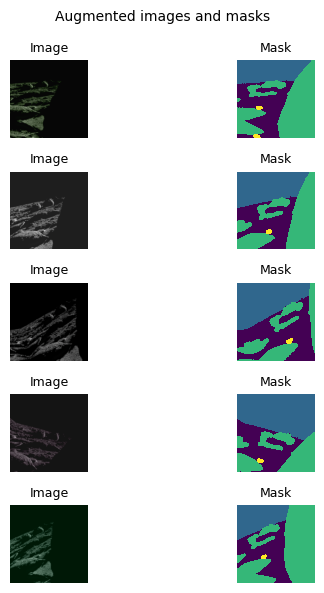

In [49]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(6, 6))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Image", fontsize=9)
        ax[i, 1].set_title("Mask", fontsize=9)
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.suptitle("Augmented images and masks", fontsize=10)
    plt.tight_layout()
    plt.show()


random.seed(42)
visualize_augmentations(train_dataset, idx=10)

**UTILITY FUNCTIONS**

In [50]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

**TRAIN AND VALIDATION FUNCTIONS**

In [51]:
def train_batch(model, data, optimizer, criterion, params):
    model.train()
    ims, ce_masks = data

    ims=ims.to(params["device"])
    ce_masks=ce_masks.to(params["device"]).long()
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, params):
    model.eval()
    ims, masks = data
    ims=ims.to(params["device"])
    masks=masks.to(params["device"]).long()
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [52]:
def train_and_validate(model, train_dataset, val_dataset, params):
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
    )
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
    )
    #criterion = nn.BCEWithLogitsLoss().to(params["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    criterion = ResnextLoss

    log = Report(params["epochs"])
    for ex in range(params["epochs"]):
      N = len(train_dataloader)
      for bx, data in enumerate(train_dataloader):
          loss, acc = train_batch(model, data, optimizer, criterion, params)
          log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

      N = len(val_dataloader)
      for bx, data in enumerate(val_dataloader):
          loss, acc = validate_batch(model, data, criterion, params)
          log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

      log.report_avgs(ex+1)
    #plot results
    log.plot_epochs(['trn_loss','val_loss'])
    log.plot_epochs(['trn_acc','val_acc'])
    return model

In [53]:
def create_model(params):
    model = smp.FPN(encoder_name='resnext50_32x4d',
                    encoder_weights='imagenet',
                    classes=params["num_classes"],
                    activation='sigmoid')
    model = model.to(params["device"])
    return model

In [54]:
def ResnextLoss(preds, targets):
    ce_loss = nn.CrossEntropyLoss()(preds, targets)
    preds = preds.to(targets.device).long()
    preds = preds.long()
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

**DEFINE TRAINING PARAMETERS**

In [55]:
params = {
    "device": DEVICE,
    "lr": 0.0001,
    "batch_size": 4,
    "num_workers": 1,
    "epochs": 20,
    "num_classes": 4
}

**TRAIN MODEL**

In [56]:
model = create_model(params)
model = train_and_validate(model, train_dataset, val_dataset, params)

EPOCH: 1.000  trn_acc: 0.736  val_acc: 0.722  trn_loss: 0.796  val_loss: 0.787  (577.90s - 10980.19s remaining)
EPOCH: 2.000  trn_acc: 0.746  val_acc: 0.781  trn_loss: 0.791  val_loss: 0.786  (1154.36s - 10389.27s remaining)
EPOCH: 3.000  trn_acc: 0.764  val_acc: 0.722  trn_loss: 0.790  val_loss: 0.786  (1730.40s - 9805.61s remaining)
EPOCH: 4.000  trn_acc: 0.793  val_acc: 0.847  trn_loss: 0.790  val_loss: 0.785  (2306.27s - 9225.07s remaining)
EPOCH: 5.000  trn_acc: 0.834  val_acc: 0.824  trn_loss: 0.790  val_loss: 0.785  (2885.07s - 8655.22s remaining)
EPOCH: 6.000  trn_acc: 0.814  val_acc: 0.862  trn_loss: 0.790  val_loss: 0.785  (3458.59s - 8070.03s remaining)
EPOCH: 7.000  trn_acc: 0.793  val_acc: 0.871  trn_loss: 0.790  val_loss: 0.785  (4034.11s - 7491.92s remaining)
EPOCH: 8.000  trn_acc: 0.824  val_acc: 0.850  trn_loss: 0.789  val_loss: 0.785  (4612.73s - 6919.09s remaining)
EPOCH: 9.000  trn_acc: 0.842  val_acc: 0.854  trn_loss: 0.789  val_loss: 0.785  (5199.19s - 6354.57s re

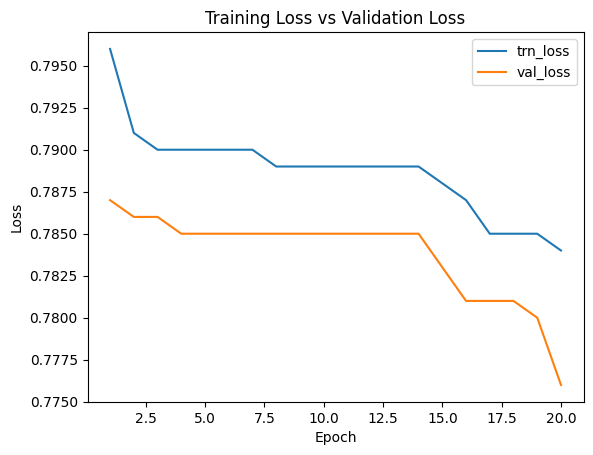

In [142]:
#the plots are typically generated by log.plot_epochs. This is a workaround for not calling it early
'''
log_df.plot(x='EPOCH', y=['trn_loss', 'val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
'''

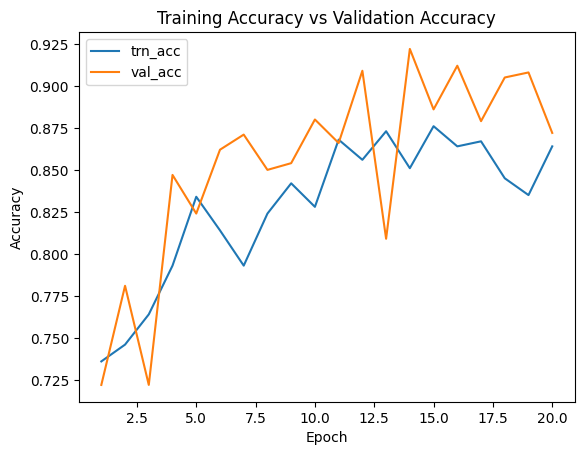

In [141]:
'''
log_df.plot(x='EPOCH', y=['trn_acc', 'val_acc'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
'''

**SAVE MODEL**

In [64]:
torch.save(model.state_dict(), f'models/FPN_epochs_{params["epochs"]}_crossentropy_state_dict.pth')

**TEST PREDICTIONS**

In [65]:
def model_evaluation(model, params, test_dataloader):
    pixel_accuracies = []
    intersection_over_unions = []
    metric_iou = torchmetrics.JaccardIndex(num_classes=params["num_classes"], task='multiclass').to(params["device"])
    print("Number of batches in test loader:", len(test_dataloader))

    with torch.no_grad():
        for images, masks in test_dataloader:
            images = images.to(params["device"], non_blocking=True).float()
            true_masks = masks.to(dtype=torch.float32)
            predicted_masks = model(images.float())

            _, predicted = torch.max(predicted_masks, 1)
            true = true_masks.to(DEVICE)
            correct_pixels = (true == predicted).sum().item()
            total_pixels = true.size(1) * true.size(2)
            pixel_accuracies.append(correct_pixels / total_pixels)
            iou = metric_iou(predicted.float(), true).item()
            intersection_over_unions.append(iou)

    # Median Accuracy
    print(f"Median Pixel Accuracy: {np.median(pixel_accuracies) * 100 }")
    print(f"Median IoU: {np.median(intersection_over_unions) * 100 }")

In [59]:
def display_next_prediction(model, params, test_dataloader):
  im, mask = next(iter(test_dataloader))
  im = im.to(params["device"]).float()
  mask = mask.to(params["device"])
  _mask = model(im)
  _, _mask = torch.max(_mask, dim=1)

  subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
  ,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
  nc=3, titles=['Original image','Original mask','Predicted mask'])

In [60]:
test_path_name = os.path.join(working_dir, 'test')
test_image_path, test_mask_path = get_images_and_masks(test_path_name)

test_transform = A.Compose(
    [A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
test_dataset = LunarDataset(image_paths=test_image_path, mask_paths=test_mask_path, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [61]:
#Model setup
model = smp.FPN(
    encoder_name="resnext50_32x4d",
    encoder_weights='imagenet',
    classes=params["num_classes"],
    activation='sigmoid',
)
model.to(DEVICE)

#%% load weights
model.load_state_dict(torch.load(f'models/FPN_epochs_{params["epochs"]}_crossentropy_state_dict.pth'))

<All keys matched successfully>

In [62]:
model_evaluation(model, params, test_dataloader)

Number of batches in test loader: 2930
Median Pixel Accuracy: 98.72705078125
Median IoU: 65.41474163532257


**DISPLAY RESULTS**

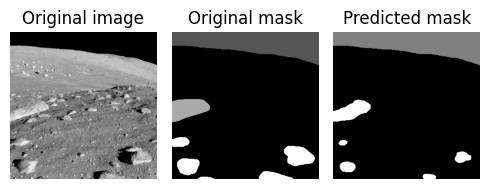

In [70]:
display_next_prediction(model, params, test_dataloader)

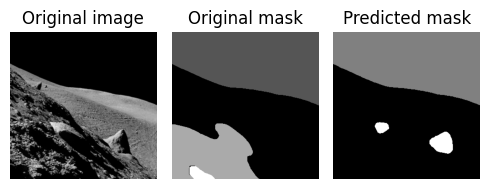

In [72]:
display_next_prediction(model, params, test_dataloader)

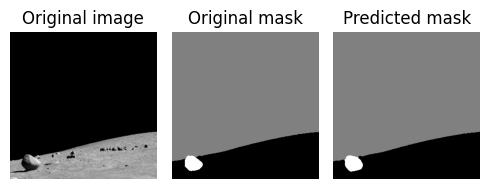

In [73]:
display_next_prediction(model, params, test_dataloader)

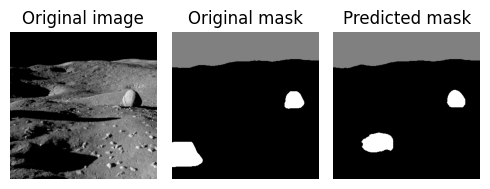

In [75]:
display_next_prediction(model, params, test_dataloader)

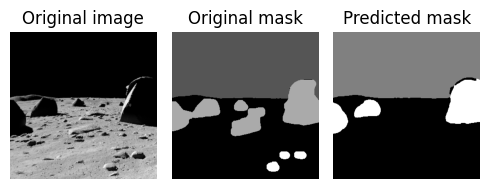

In [128]:
display_next_prediction(model, params, test_dataloader)